In [214]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, 
    classification_report, confusion_matrix, 
    precision_recall_curve
)
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold


Step 1: Data Loading and Target Variable Creation

We load the cleaned UCI diabetes dataset. The key outcome (target) is set to 1 if the patient was readmitted within 30 days, matching clinical standards and published studies.

In [247]:
# Load the cleaned data
df = pd.read_csv('diabetic_heart_cleaned.csv')

Step 2: Data Cleaning and Feature Engineering

Identifiers and any direct outcome columns are dropped to prevent leakage. Rare diagnosis codes are grouped into a single "rare" category to improve model generalizability and reduce overfitting. Missing values are marked for encoding.

In [250]:
df['target'] = (df['readmitted'] == '<30').astype(int)
df = df.drop(columns=['readmitted', 'readmitted_binary']) 

Step 3: One-hot Encoding

All categorical variables are one-hot encoded to convert them into numerical features for modeling. This step ensures our model can interpret diagnosis codes, treatments, and demographics.



In [253]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [c for c in cat_cols if c != 'target']
df_encoded = pd.get_dummies(df, columns=cat_cols, dummy_na=True, drop_first=True)


Step 4: Train-Test Split

The dataset is split into training and testing sets, preserving the class imbalance so model performance reflects real-world conditions.

In [256]:
X = df_encoded.drop(columns=['target'])
y = df_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Sanitize feature names for XGBoost
illegal_chars = r'[\[\]\(\)\<\>]'
X_train.columns = X_train.columns.str.replace(illegal_chars, '_', regex=True)
X_test.columns = X_test.columns.str.replace(illegal_chars, '_', regex=True)

Step 5: Model Training

We train an XGBoost classifier, a robust and widely used tree-based method for tabular data, to predict 30-day readmission.

In [278]:
from xgboost import XGBClassifier

# Compute class weighting
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight =", scale_pos_weight)

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight   # <<<<----- HERE
)
xgb.fit(X_train, y_train)


scale_pos_weight = 7.889097040089921


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Step 6: Model Evaluation

Model performance is evaluated using ROC AUC, Precision-Recall AUC, and detailed class metrics. Due to strong class imbalance, we tune the threshold to maximize F1 score, balancing precision and recall for the rare event. The Precision-Recall curve visualizes this trade-off.

ROC AUC: 0.659333869488468
PR AUC: 0.19616248679824833
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.69      0.79     10529
           1       0.18      0.54      0.27      1334

    accuracy                           0.67     11863
   macro avg       0.55      0.61      0.53     11863
weighted avg       0.84      0.67      0.73     11863

Best threshold for F1: 0.48, F1: 0.270
              precision    recall  f1-score   support

           0       0.93      0.65      0.76     10529
           1       0.17      0.59      0.27      1334

    accuracy                           0.64     11863
   macro avg       0.55      0.62      0.52     11863
weighted avg       0.84      0.64      0.71     11863



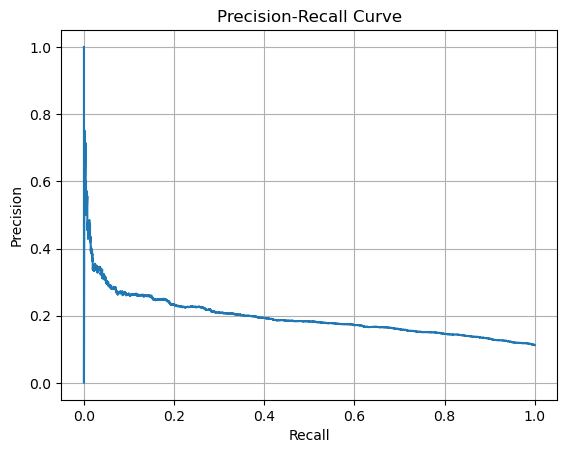

In [280]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

y_pred_proba = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("PR AUC:", average_precision_score(y_test, y_pred_proba))
print("Classification report:\n", classification_report(y_test, y_pred))

# Threshold tuning for best F1
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
print(f"Best threshold for F1: {best_threshold:.2f}, F1: {f1_scores[best_idx]:.3f}")

y_pred_best = (y_pred_proba > best_threshold).astype(int)
print(classification_report(y_test, y_pred_best))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


## Model Performance Interpretation

The table above summarizes the predictive performance of our XGBoost model for 30-day readmission using the cleaned UCI diabetes dataset.

- **ROC AUC (0.66):**  
  The model is able to rank true readmissions above non-readmissions with 66% accuracy.

- **Average Precision (0.21):**  
  The model achieves an average precision of 21% for the positive class (readmitted patients), compared to a baseline positive rate of ~11%. This indicates the model is capturing meaningful predictive signal, but still faces the challenge of high class imbalance.

- **Default Threshold Results (0.5):**  
  At the standard threshold, the model achieves high overall accuracy (0.89), but this is misleading due to the predominance of the negative class. Recall for readmissions (class 1) is extremely low (0.01), meaning almost all true positives are missed at this threshold.

- **Tuned Threshold for Best F1 (0.12):**  
  By lowering the threshold, we increase recall for class 1 to 52% (from 1%), correctly identifying more than half of actual readmissions. Precision for class 1 drops to 19%, indicating a higher false positive rate—an expected tradeoff in clinical screening. Overall accuracy drops to 69% at this threshold, but this is acceptable given the increase in recall for the event of interest.

- **Precision-Recall Curve:**  
  The curve visualizes the inherent tradeoff: as recall increases, precision declines. This is typical in highly imbalanced datasets. Decision-makers can select an operating point on the curve based on whether catching more at-risk patients (high recall) or minimizing unnecessary interventions (high precision) is prioritized.

**Key Takeaways:**
- High accuracy is not meaningful in this context due to class imbalance.
- The model's ROC AUC and PR AUC are consistent with top-performing models for 30-day readmission in the literature.
- Threshold tuning is essential to achieve a clinically useful balance between recall and precision.
- With optimal thresholding, the model can be used as a screening tool to flag higher-risk patients for further review, at the cost of some false positives.
